# Project Goals
## Overview
## The Problem: Finding a Needle in a Haystack

> Elevator Pitch / What we want to accomplish

# The Data: First Look

Let's get our data into a dataframe to examin it:

In [1]:
import src.wrangle
import src.explore
import src.preprocessing
import src.features

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = src.wrangle.get_raw_data()
data_dict = pd.read_csv('data/WiDS Datathon 2020 Dictionary.csv')

df.head()

,encounter_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
patient_id,,,,,,,,,,,,,,,,,,,,,
25312,66154,118,0,68.0,22.73,0,Caucasian,M,180.3,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
59342,114252,81,0,77.0,27.42,0,Caucasian,F,160.0,Floor,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
50777,119783,118,0,25.0,31.95,0,Caucasian,F,172.7,Emergency Department,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
46918,79267,118,0,81.0,22.64,1,Caucasian,F,165.1,Operating Room,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
34377,92056,33,0,19.0,NaN,0,Caucasian,M,188.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


## Size of the Raw Data

In [2]:
print(f'''Number of Columns: {df.shape[1]}, Number of Rows: {df.shape[0]}''')

Number of Columns: 185, Number of Rows: 91713


> This means that we have *91,713* patients in our dataset, with *185* metrics recorded for each of them within that 24 hour period. That's quite a bit of data.

## Number of Hospitals

In [3]:
print(f'Number of hospitals: {df.hospital_id.nunique()}')

Number of hospitals: 147


## Imbalanced Data

Our goal for this project is to predict patient survivability, so what does that distribution look like in our data?

In [4]:
num_patients_died = len(df[df.hospital_death == 1])
print('Percentage of patients who did not survive: {: .2f}'.format(num_patients_died / len(df)))

Percentage of patients who did not survive:  0.09


>*91* percent of the patients survived their time in the ICU, while only *9* percent did not. 

While this is great news in terms of ICU survival rates, it means we're dealing with an imbalanced dataset which is going to raise its own challenges as we move forward.

## Quick Look at the Missing Values

We'll be using a library called [missingno]('https://github.com/ResidentMario/missingno') to visualize the missing values within the data.

demographic


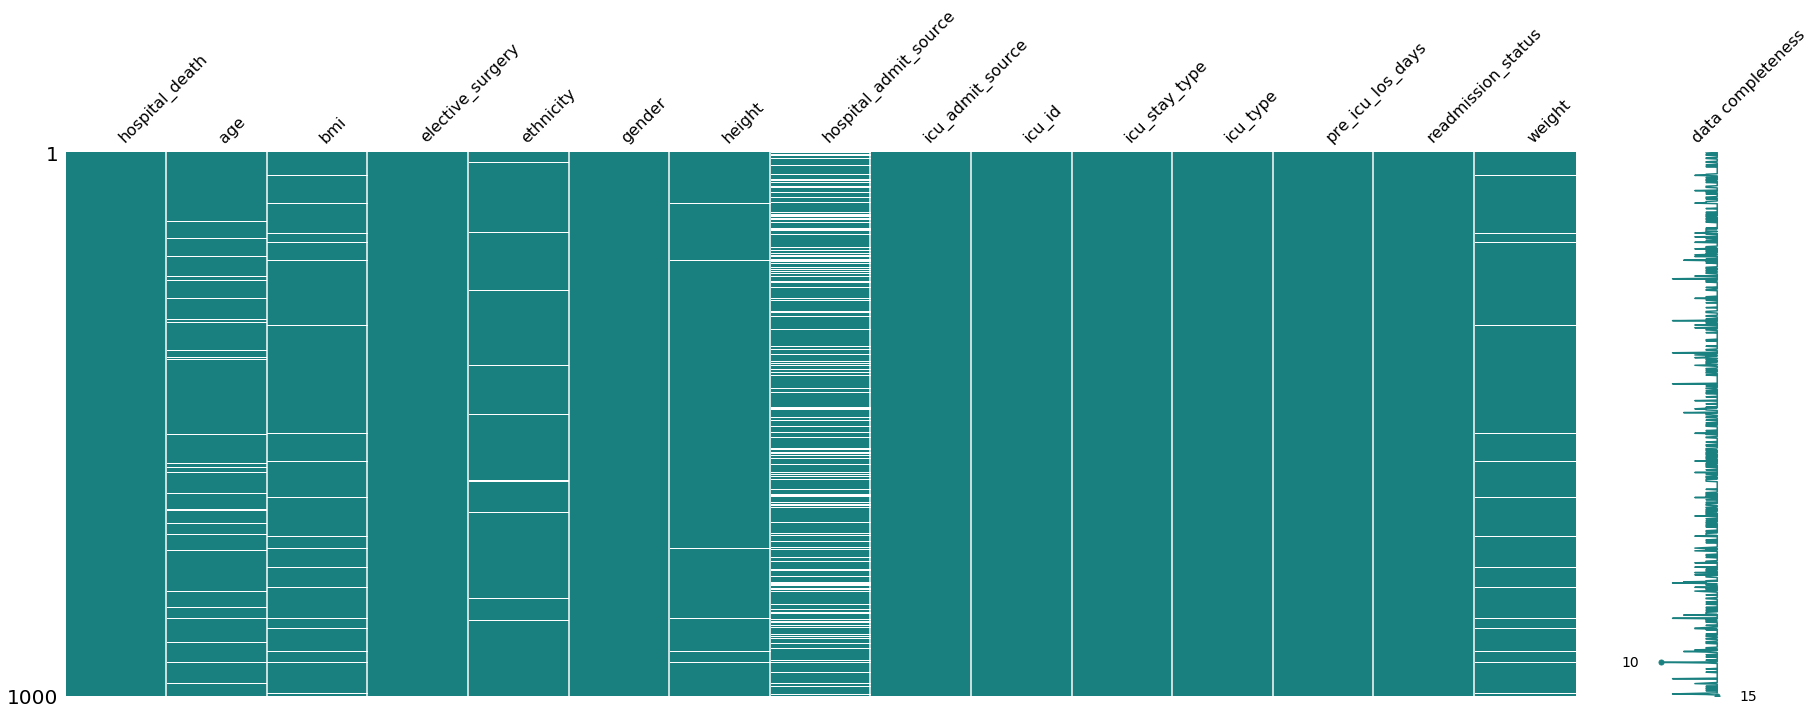

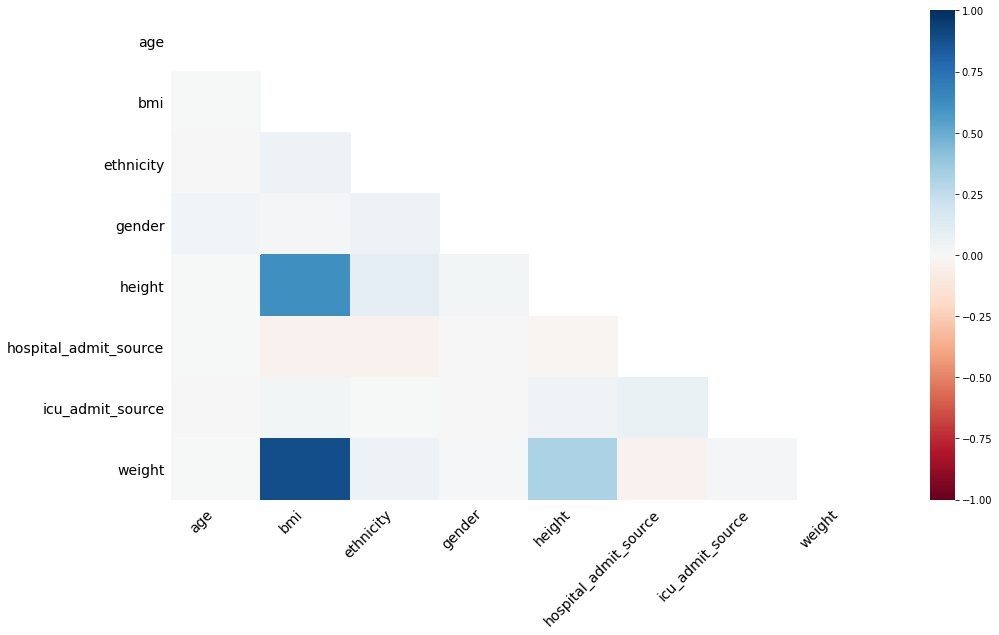

APACHE covariate


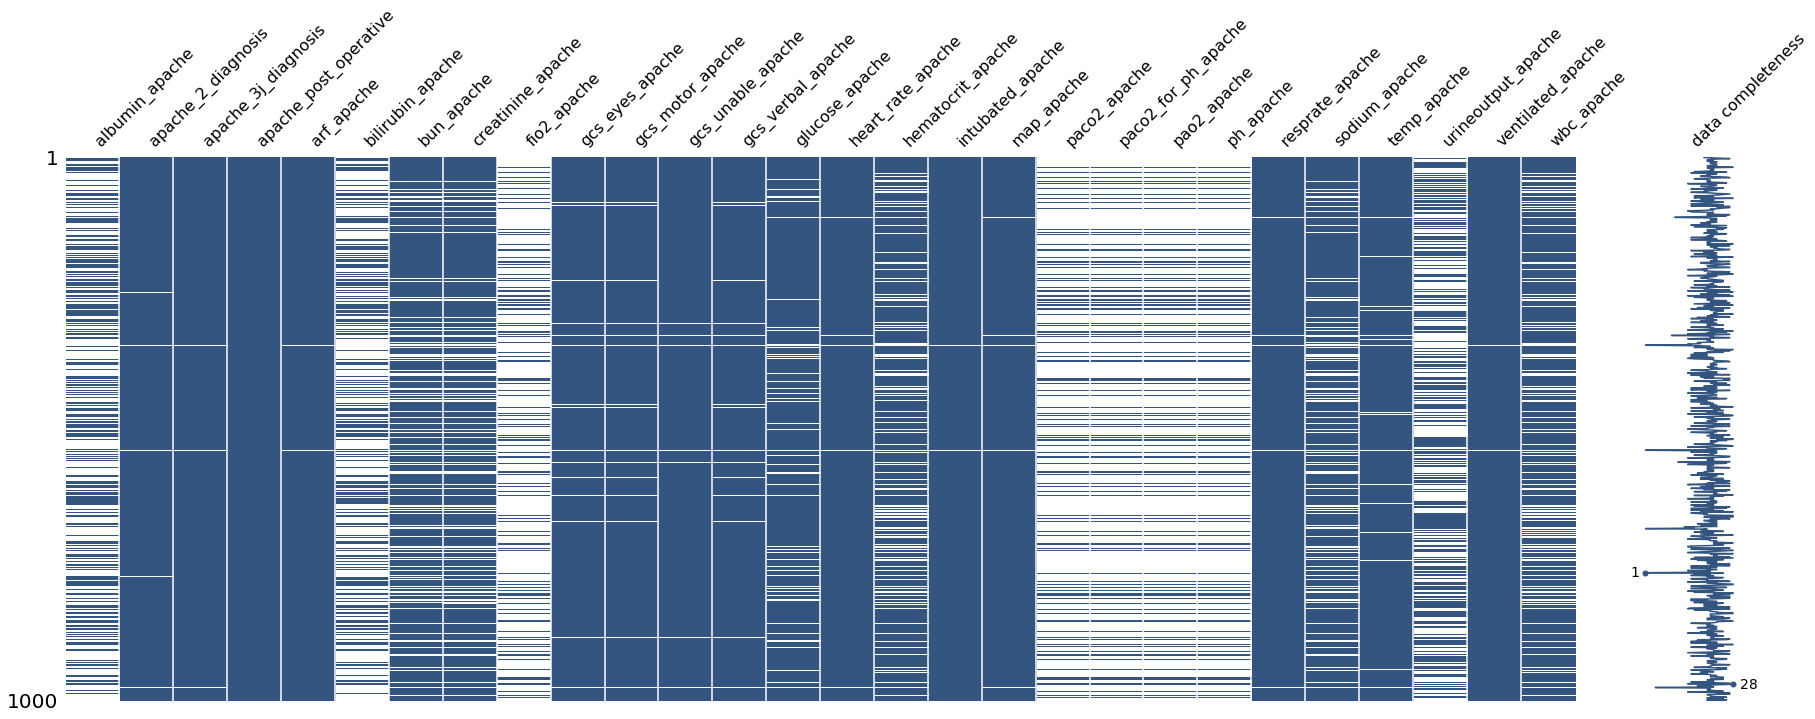

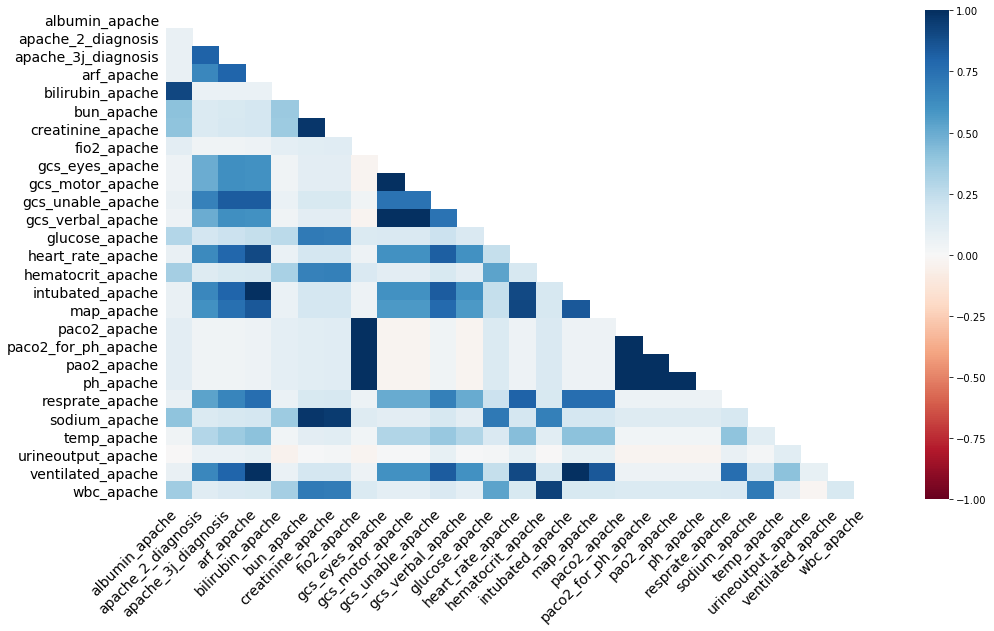

vitals


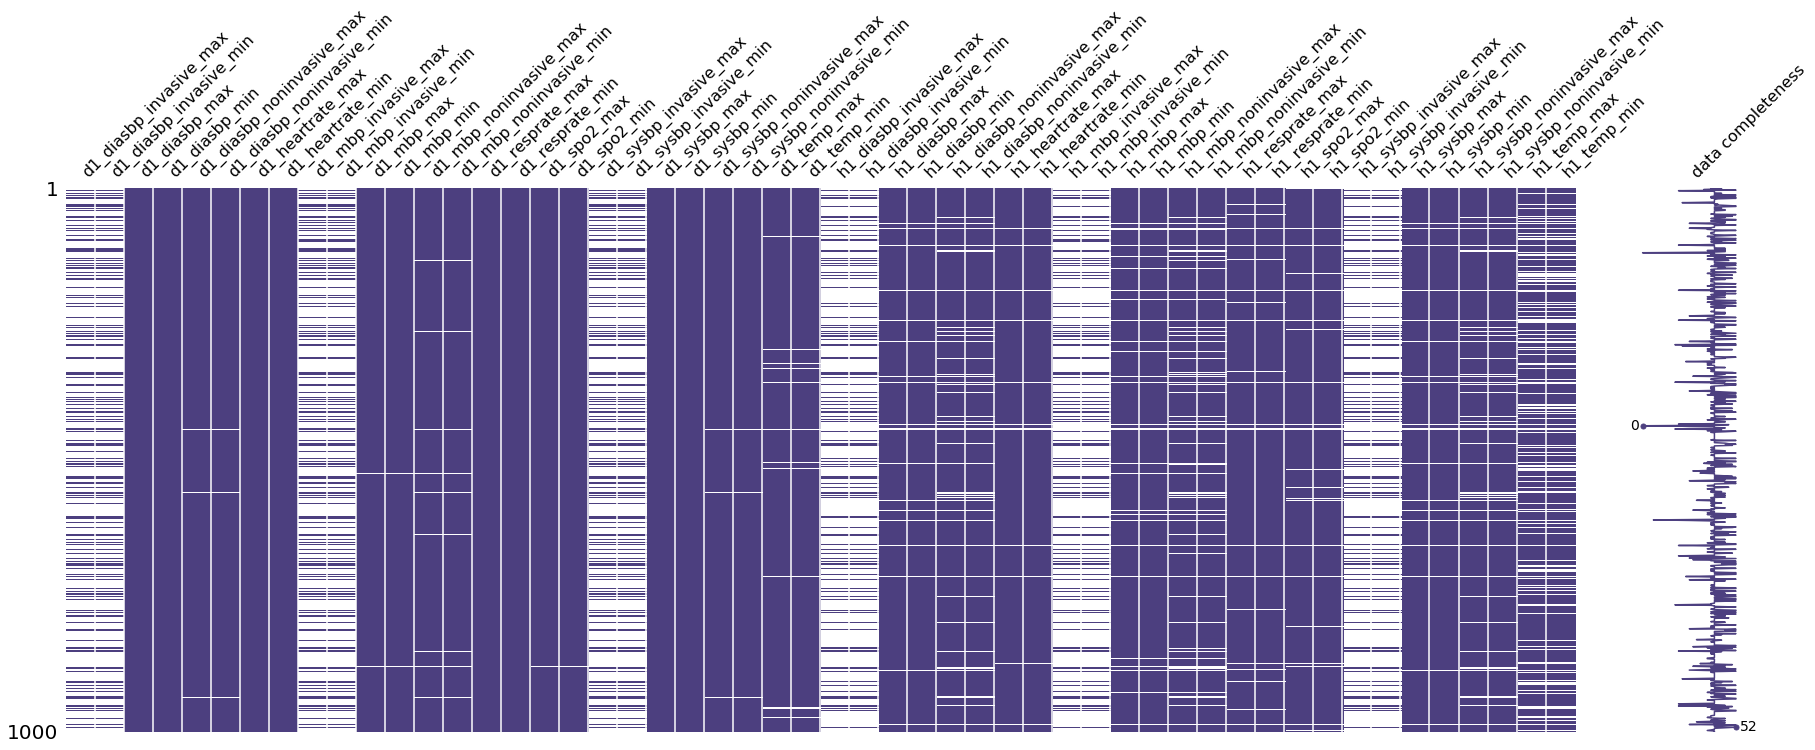

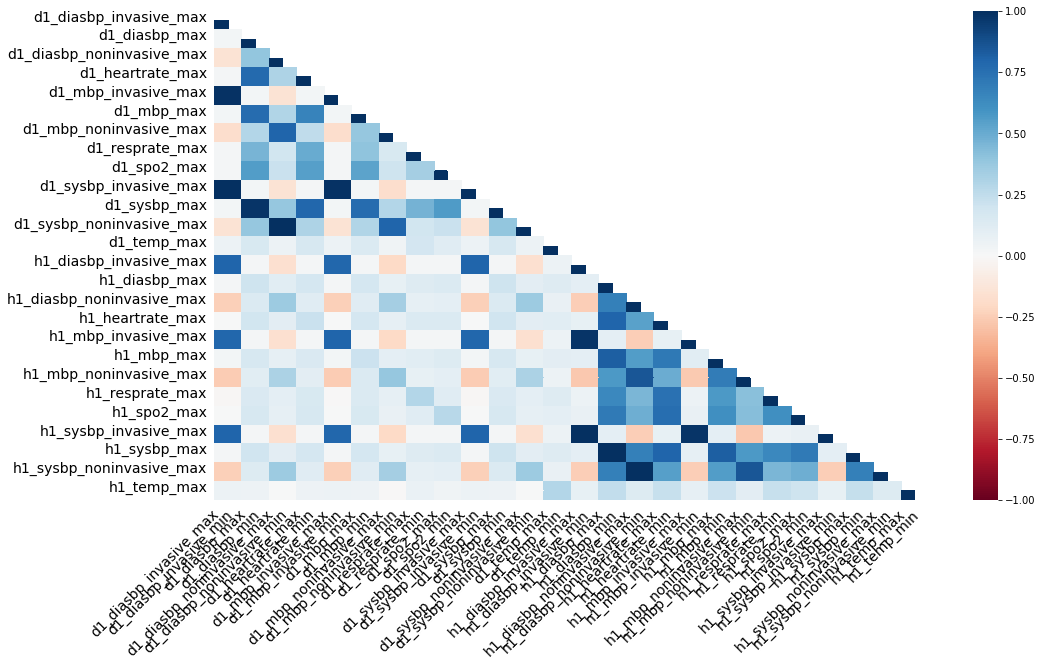

labs


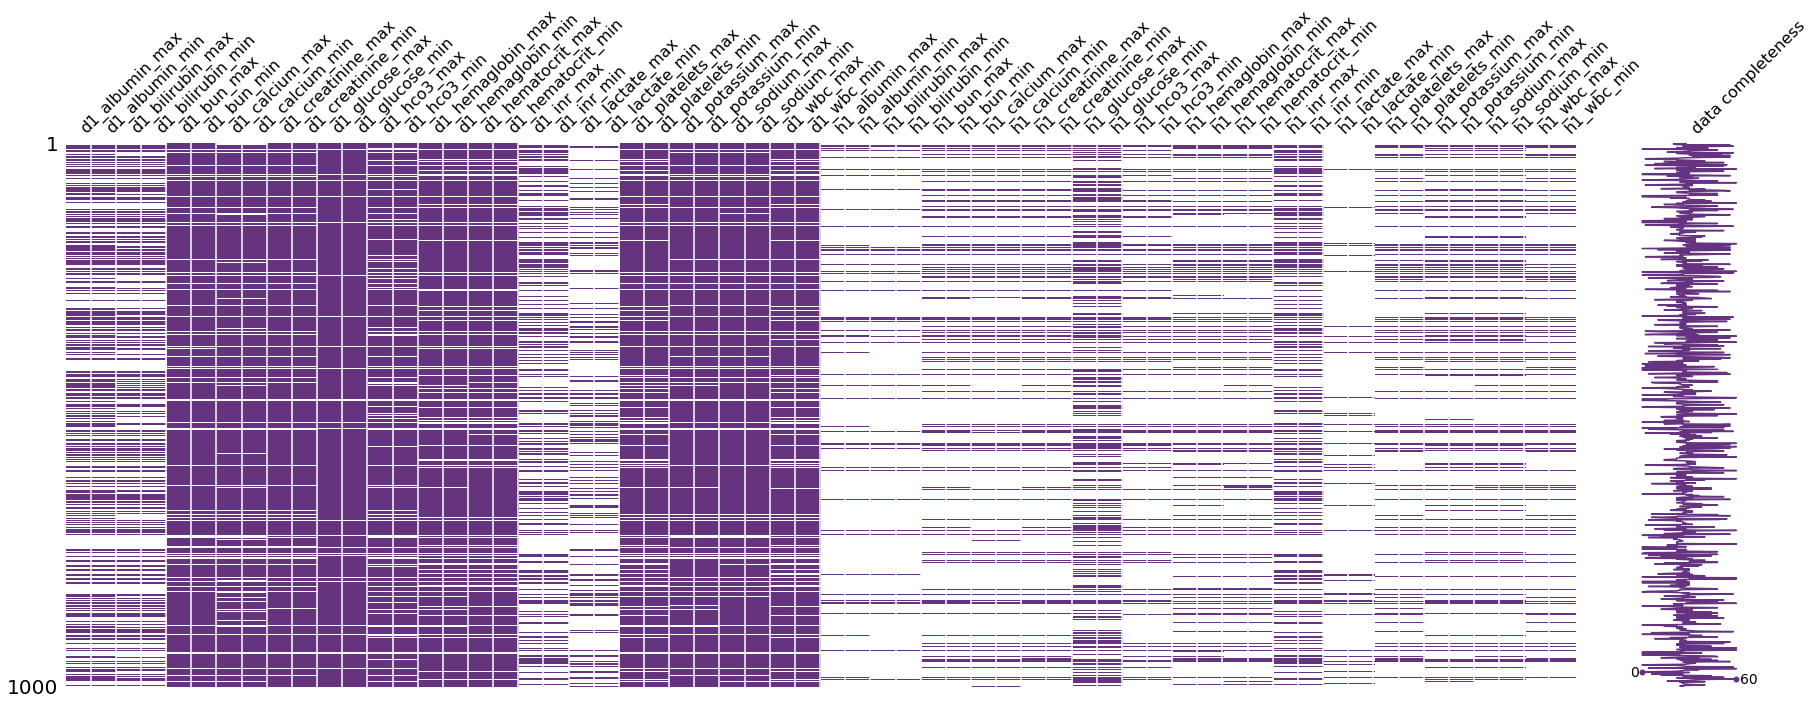

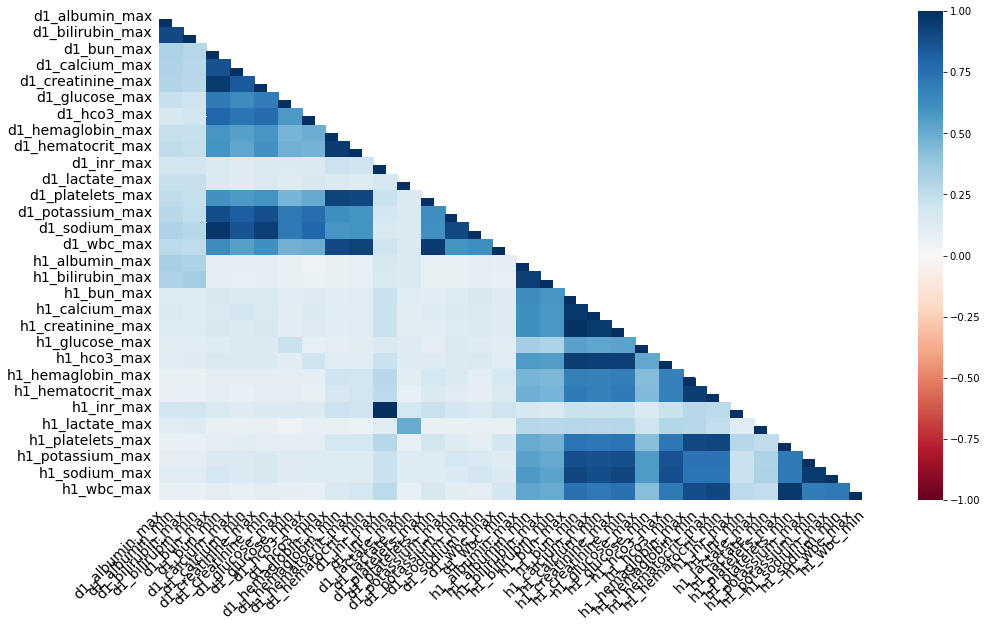

labs blood gas


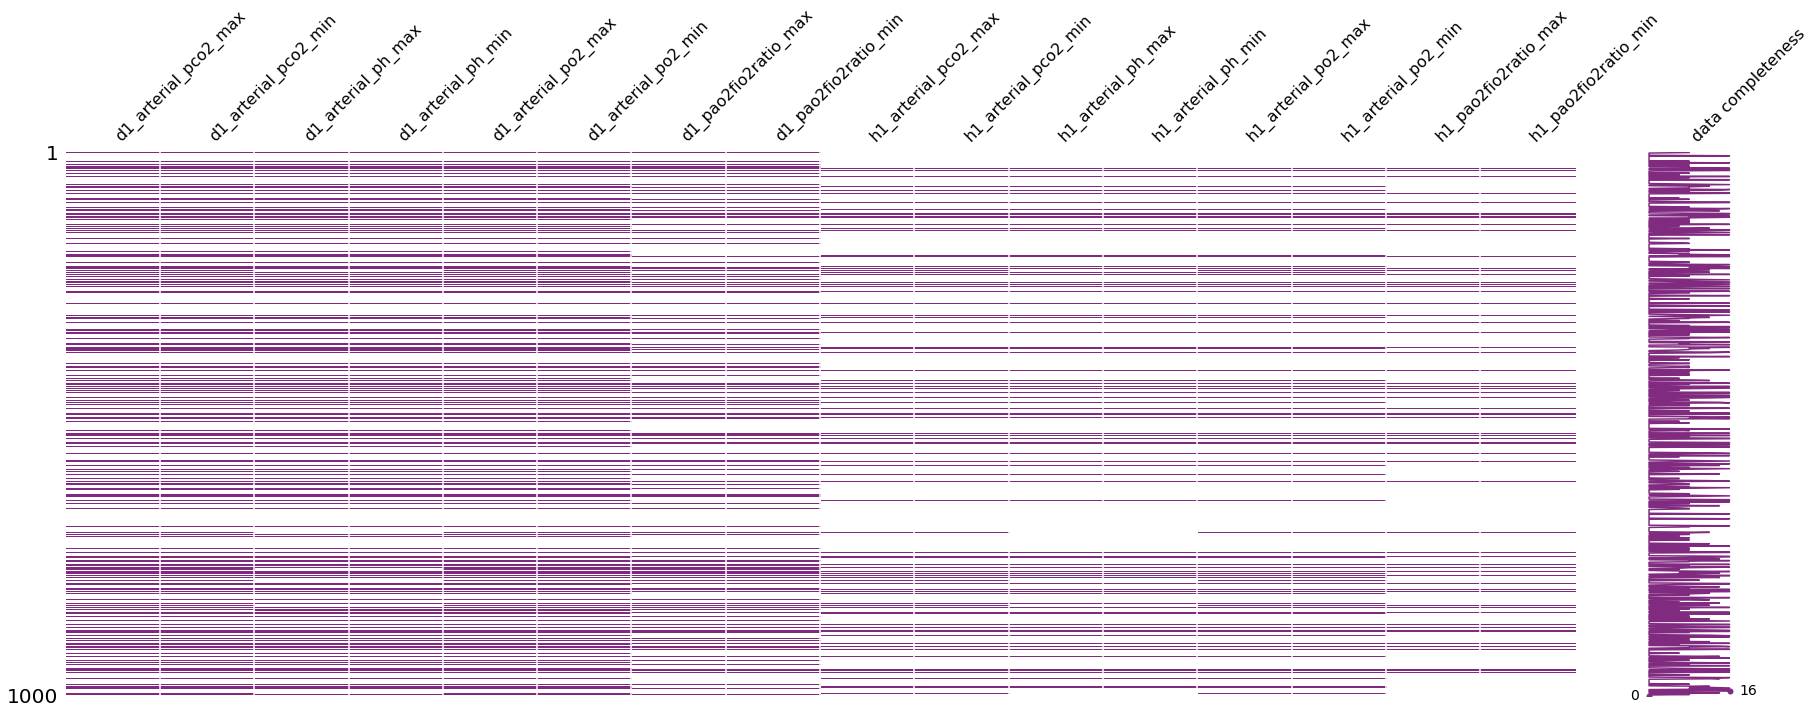

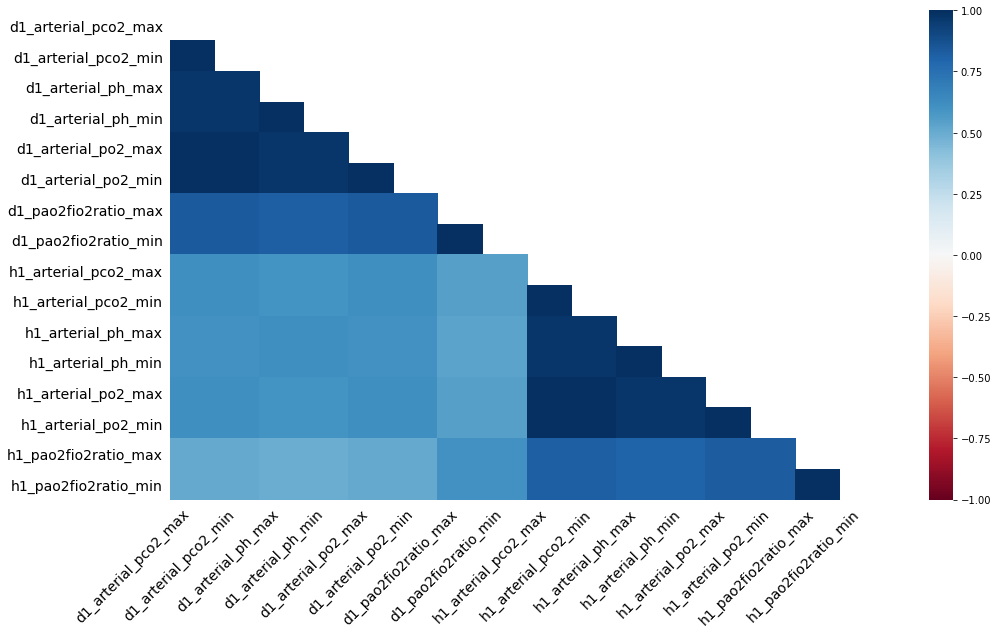

APACHE prediction


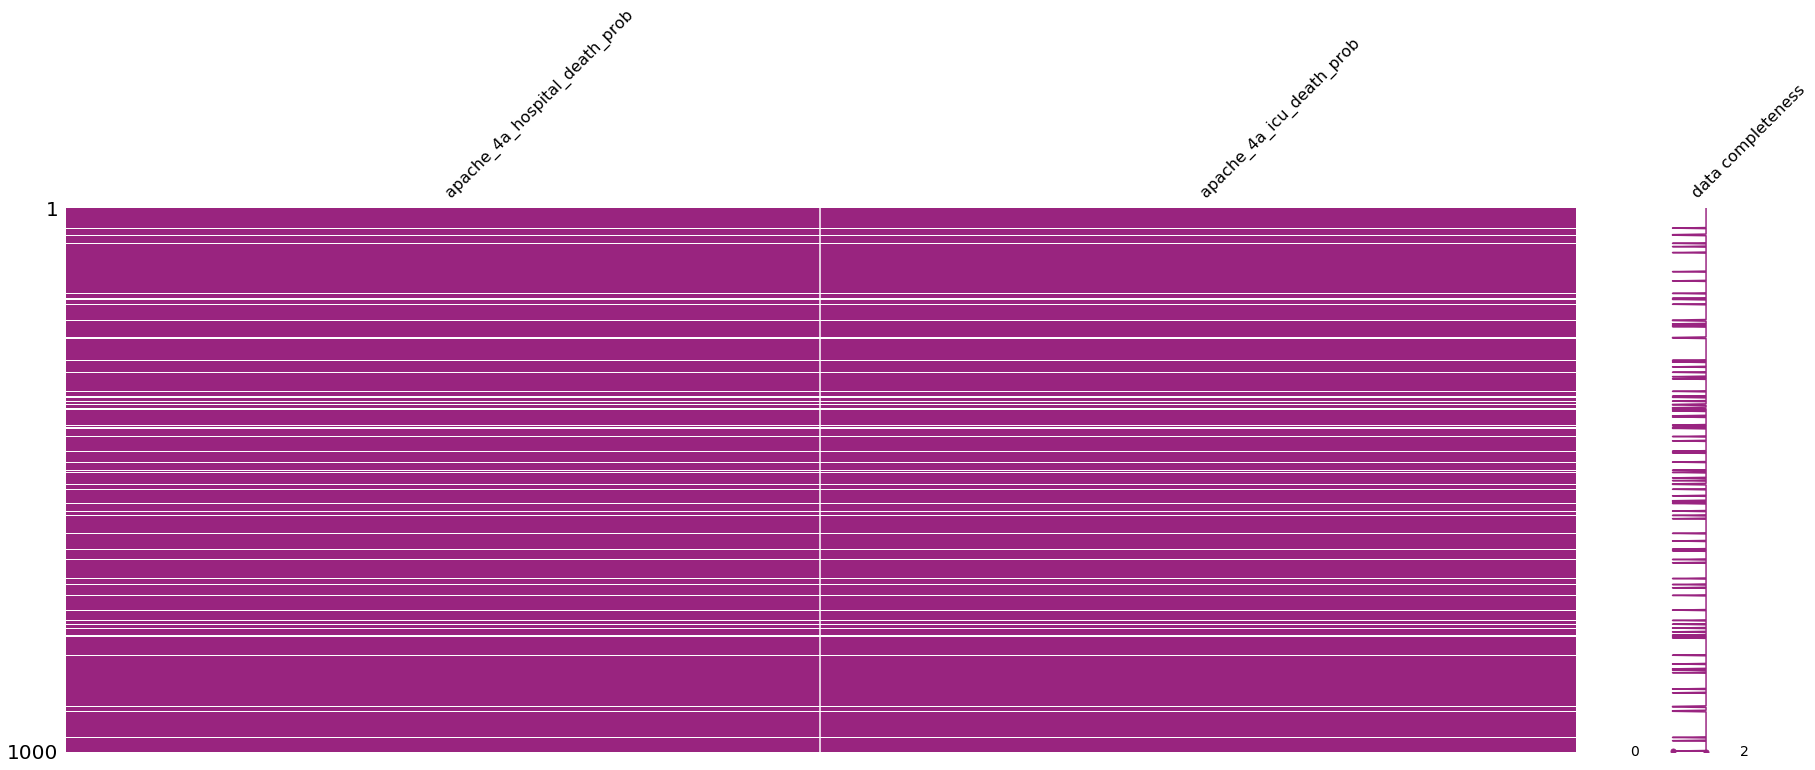

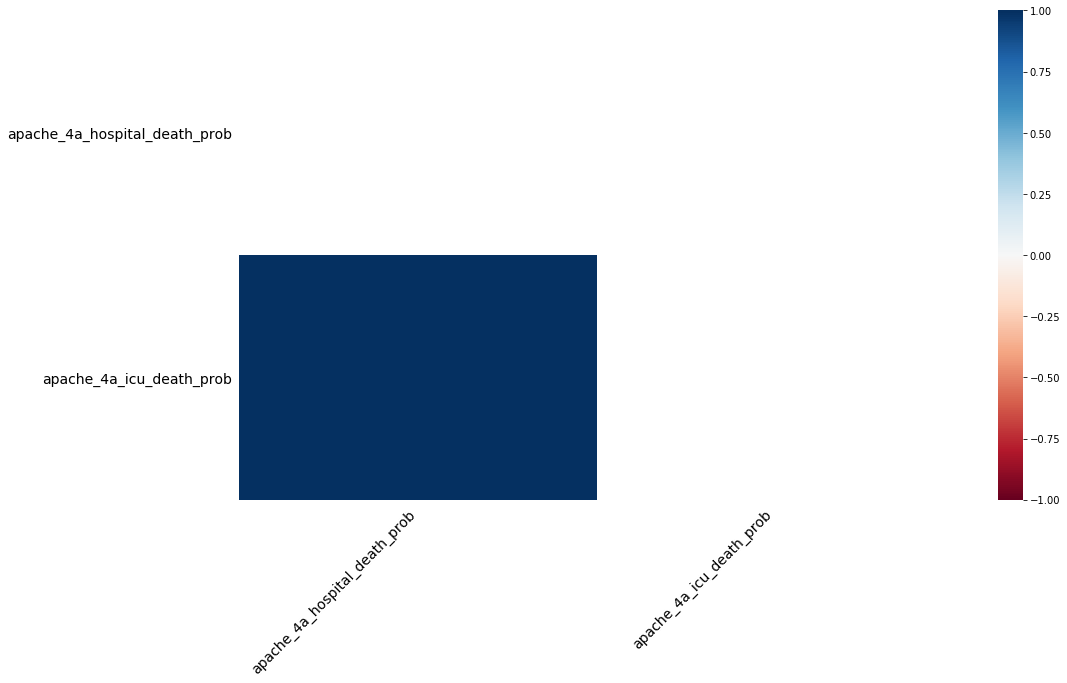

APACHE comorbidity


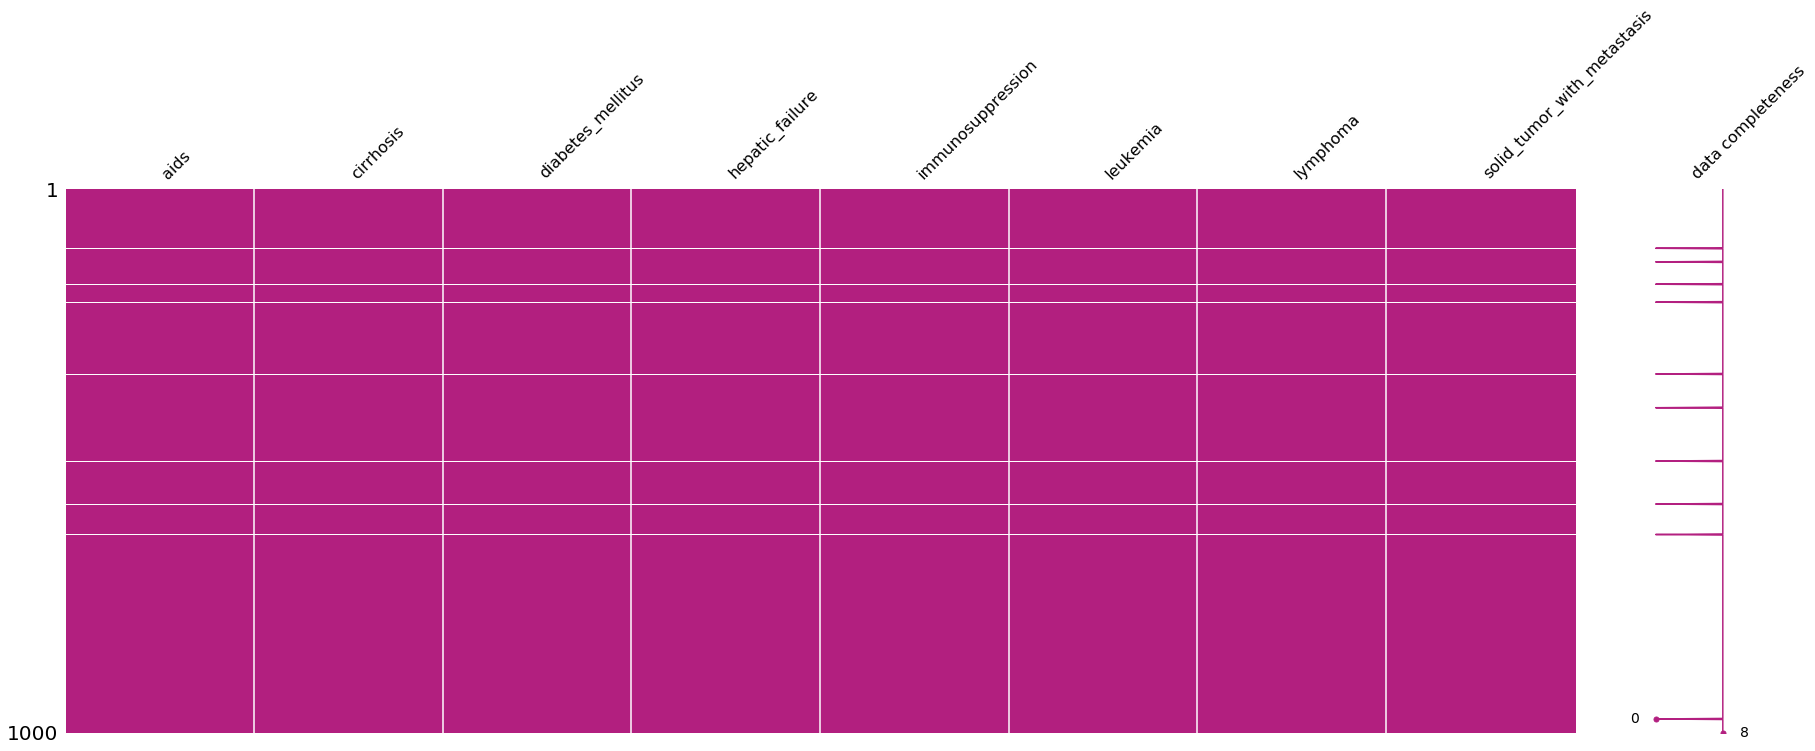

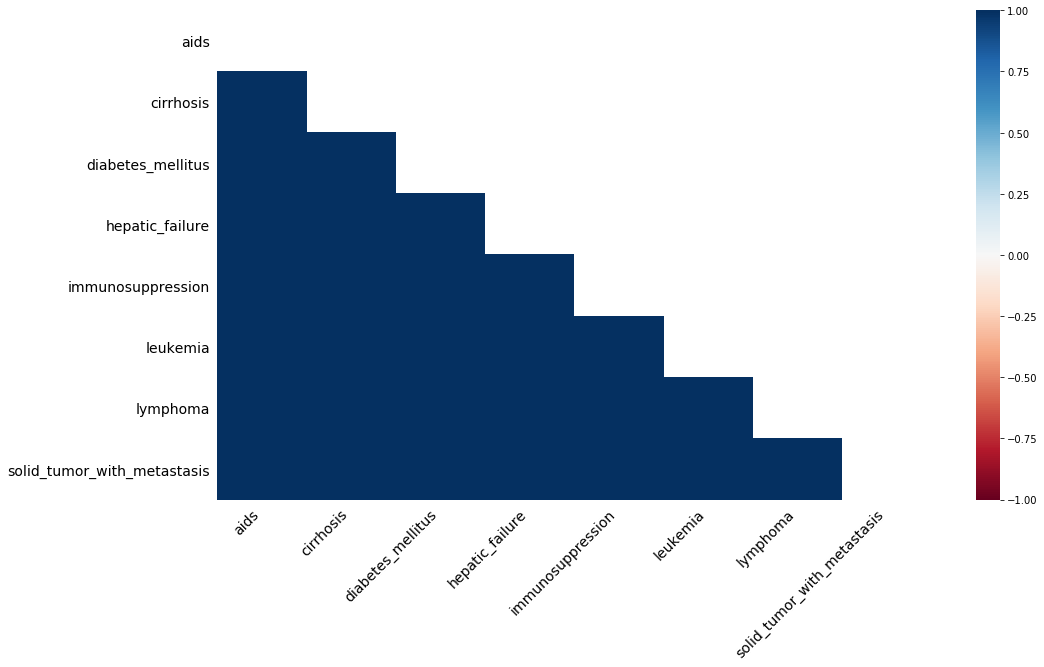

APACHE grouping


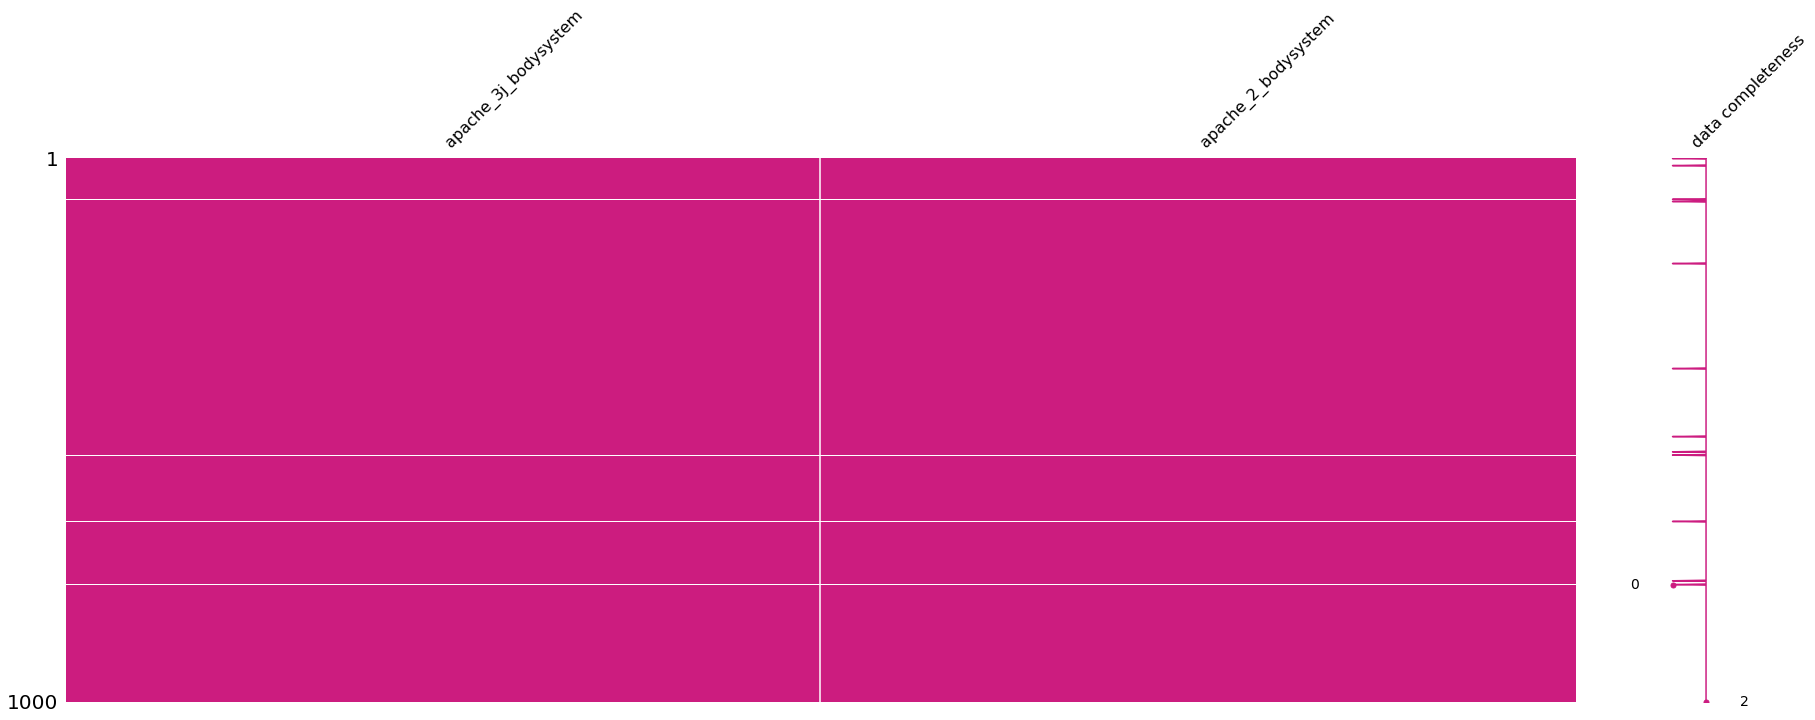

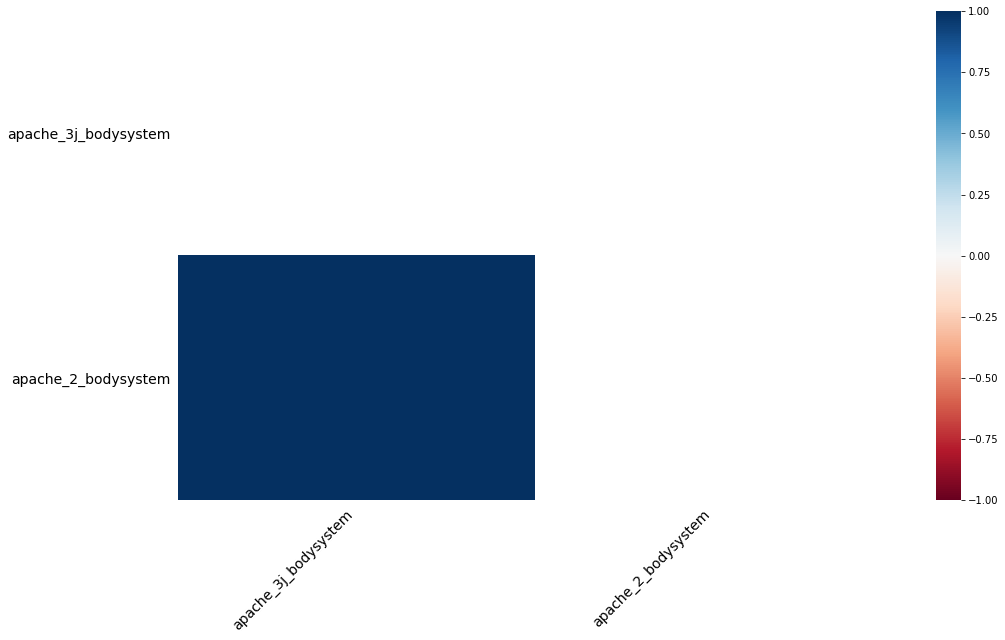

In [5]:
import missingno as msno
import matplotlib.pyplot as plt

for color, variable in enumerate(data_dict["Category"].unique()):
    if variable not in ["GOSSIS example prediction", "identifier"]:
        print(variable)
        column_list = data_dict[data_dict["Category"] == variable]["Variable Name"].values.tolist()
        column_list = [f for f in column_list if f in df.columns]
        if len(column_list) > 0:
            msno.matrix(
                df[column_list].sample(1000),
                figsize=(30, 10),
                labels=True,
                color=(color / 10, 1 / (color + 1), 0.5),
                fontsize=16,
            )
            msno.heatmap(
                df[column_list], figsize=(16, 9), labels=False, fontsize=14
            )
            plt.show()

# Preparation: Challenges Faced and How We Handled Them

## Null Values: A Different Beast in an Imbalanced Data Set
Since our target value (patient survivability) we're attempting to predict is imbalanced in our dataset, this affects our ability to handle nulls through blanket fixes. What we'll have to do is correlate the significance of the missing values against our target value to identify if the missing values are actually playing a role in patient survivability. 

> Below, we've run through each feature in our dataset to identify if the feature is dependent or independent of hospital_death. 

In [6]:
src.explore.significance_testing_of_nulls(df)

(encounter_id and hospital_death) are  independent of each other. (p = 0.4984475106646044)
(hospital_id and hospital_death) are  dependent of each other. (p = 3.971188907548724e-148)
(hospital_death and hospital_death) are  dependent of each other. (p = 0.0)
(age and hospital_death) are  dependent of each other. (p = 4.3986226670688454e-204)
(bmi and hospital_death) are  independent of each other. (p = 0.10323036630688469)
(elective_surgery and hospital_death) are  dependent of each other. (p = 1.8111023373323387e-176)
(ethnicity and hospital_death) are  dependent of each other. (p = 0.0031164745025517304)
(gender and hospital_death) are  dependent of each other. (p = 0.03441709366041668)
(height and hospital_death) are  dependent of each other. (p = 0.0021710052871524873)
(hospital_admit_source and hospital_death) are  dependent of each other. (p = 1.2519350471326363e-197)
(icu_admit_source and hospital_death) are  dependent of each other. (p = 3.7031521455538844e-243)
(icu_id and hos

(d1_albumin_max and hospital_death) are  dependent of each other. (p = 6.859150280616564e-281)
(d1_albumin_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bilirubin_max and hospital_death) are  dependent of each other. (p = 6.817187257896686e-175)
(d1_bilirubin_min and hospital_death) are  dependent of each other. (p = 1.7869567361663835e-152)
(d1_bun_max and hospital_death) are  dependent of each other. (p = 0.0)
(d1_bun_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_calcium_max and hospital_death) are  dependent of each other. (p = 1.8212443271242305e-270)
(d1_calcium_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_creatinine_max and hospital_death) are  dependent of each other. (p = 0.0)
(d1_creatinine_min and hospital_death) are  dependent of each other. (p = 0.0)
(d1_glucose_max and hospital_death) are  dependent of each other. (p = 1.9842998271708244e-87)
(d1_glucose_min and hospital_death) are  dependent of each other.

What do we get from this? This helped us identify the features which were independent of our target variable, and much more useful for our models than the other features. 

## Splitting the Data

Now that we've taken a look at the data in broad strokes, it's time to split it so we're not spoiling our test data.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.drop(columns="hospital_death")
y = df.hospital_death
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

## Applying Wrangle to the Split Data

In [9]:
for df in [X_train, X_test]:
    df.pipe(src.wrangle.prepare_data)

In [10]:
# Making sure there's no missing data in the X split
X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [11]:
# Making sure there's no missing data in the y split
y_train.isna().sum().sum(), y_test.isna().sum().sum()

(0, 0)

# Exploration: Examining Which Factors are Affecting Patient Survival

In [12]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

## Does the Amount of Time in the ICU Affect Survival Rate?

In [13]:
ICU_day = df[df["pre_icu_los_days"] >= 0][
    ["icu_type", "pre_icu_los_days", "hospital_death"]
]
ICU_day["icu_type"] = ICU_type["icu_type"].replace(
    {
        "MICU": "Medical ICU",
        "Neuro ICU": "Neurology ICU",
        "CCU-CTICU": "Cardiothoracic ICU",
        "CTICU": "Cardiothoracic ICU",
        "SICU": "Surgical ICU ",
        "CSICU": "Cardiac Surgery ICU",
        "Med-Surg ICU": "Medical Surgical ICU"
    }
)
ICU_day["pre_icu_los_days"] = ICU_day["pre_icu_los_days"].round(0)
ICU_df = ICU_day.groupby(["icu_type", "pre_icu_los_days"]).mean().reset_index()
ICU_df["count"] = (
    ICU_day.groupby(["icu_type", "pre_icu_los_days"])
    .sum()
    .reset_index()["hospital_death"]
)

fig = px.scatter(
    ICU_df,
    x="pre_icu_los_days",
    y="hospital_death",
    size="count",
    color="icu_type",
    hover_name="icu_type",
    log_x=True,
    size_max=200,
)

fig.update_layout(legend_title_text='ICU Type')
fig.update_layout(
    title_text="<b>Survival rate at different length of stay before ICU admission<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(
    title_text="<b>The length of stay of the patient between hospital admission and unit admission <b>"
)
fig.show()

# Uncomment this code to create the HTML file to embed chart
#pio.write_html(fig, file='index.html', auto_open=True)

KeyError: "['hospital_death'] not in index"

# Feature Engineering

# Modeling: Bringing it All Together

## Encoding the Data

In [ ]:
X_train_cols_to_encode = [col for col in X_train.columns if X_train[col].dtype == object]
X_test_cols_to_encode = [col for col in X_test.columns if X_test[col].dtype == object]
X_train = src.preprocessing.encode(X_train, X_train_cols_to_encode)
X_test = src.preprocessing.encode(X_test, X_test_cols_to_encode)

In [ ]:
X_train.head(1)

## Applying Models

In [ ]:
import src.model_eval
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l2', max_iter=1000)
logit.fit(X_train, y_train)

In [ ]:
src.model_eval.evaluate_auc(logit, X_train, y_train, 'Logistic Regression: Train')

In [ ]:
src.model_eval.evaluate_auc(logit, X_test, y_test, 'Logistic Regression: Test')

### Decision Tree

In [ ]:
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

Results on the Training Data:

In [ ]:
src.model_eval.evaluate_auc(tree, X_train, y_train, 'Decision Tree: Train')

Results on the Test Data:

In [ ]:
src.model_eval.evaluate_auc(tree, X_test, y_test, 'Decision Tree: Test')

**Identifying which features were the most impactful to the Decision Tree model:**

In [ ]:
src.model_eval.get_feature_importance(X, tree.feature_importances_)

### Random Forest

### XG Boost

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=5, gamma=0.25, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, reg_alpha=0.0001, seed=27)
xgb.fit(X_train, y_train)

In [ ]:
src.model_eval.evaluate_auc(xgb, X_train, y_train, 'XG Boost: Train')

In [ ]:
src.model_eval.evaluate_auc(xgb, X_test, y_test, 'XG Boost: Test')

### Light GBM

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 6
params['min_child_weight'] = 1
params['n_estimators'] = 350
clf = lgb.train(params, d_train, 350)

In [ ]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))

y_pred=clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red', lw=2, label='Light GBM Train (area = %0.4f)' % auc(fpr, tpr))
         
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle= '-', label = 'Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

# Conclusion

Our project gave us insight into indentifying two key patient groups: patients who are at high risk of dying, and __patients who were at a low risk of dying yet still succumbed to their injuries__.

Let's use the best performing model, our __light GBM model__ to look at some examples of these two groups:

In [ ]:
# Applying our Light GBM Model to our data
final_data = X_train
final_data['predicted_survival'] = clf.predict(X_train)
final_data['actual_patient_outcome'] = y_train

In [ ]:
final_results = final_data[['actual_patient_outcome', 'predicted_survival']]

We'll be using final_results to look at a comparison between the actual patient outcome, and what our model predicted.
>__Keep in mind that the close to 1 for the prediction, the model predicted the patient was more likely not to survive__

## High Risk Patients 

In [ ]:
above_80 = final_results.predicted_survival > .8
survived = final_results.actual_patient_outcome == 0
did_not_survive = final_results.actual_patient_outcome == 1

In [ ]:
len(final_results[above_80]) / len(final_results)

1 Percent of the patients in our data were predicted to have above an 80 percent chance of dying. Let's see how accurate the model was at predicting the outcomes for those it predicted above 80%:

In [ ]:
len(final_results[above_80 & did_not_survive]) / len(final_results[above_80])

So our model does a pretty good job of identifying high risk patients and accurately predicting they are unlikely to survive. __But what about those cases where the patient survived?__

In [ ]:
len(final_results[above_80 & survived]) / len(final_results[above_80])

## Patients With Low Probability of Dying who Didn't Survive

In [ ]:
below_30 = final_results.predicted_survival < .3

In [ ]:
len(final_results[below_30]) / len(final_results)

91% of the patients were predicted to have a low risk of dying in the ICU. Let's see how many of those patients actually did not survive:

In [ ]:
len(final_results[below_30 & did_not_survive]) / len(final_results[below_30])

In [ ]:
# Number of patients assessed to have less than a 30% chance of dying who did not survive
len(final_results[below_30 & did_not_survive])